In [ ]:
# default_exp data.preparation

# Data preparation

> Functions required to prepare X (and y) from a pandas dataframe.

In [ ]:
#export
from tsai.imports import *
from tsai.utils import *
from tsai.data.validation import *

In [ ]:
#export
def df2xy(df, feat_col=None, target_col=None, data_cols=None, to3d=True, splits=None):
    r"""
    This function allows you to transform a pandas dataframe into X and y numpy arrays that can be used to craete a TSDataset.
    feat_col: used for multivariate datasets. It indicates which is the column that indicates the feature by row.
    target_col: indicates the column/s where the target is.
    data_col: indicates where the data is located. If None, it means all columns (excpet the target)
    """
    no_data_cols = []
    if feat_col is not None: no_data_cols.append(feat_col[0] if is_listy(feat_col) else feat_col)
    if target_col is not None: no_data_cols.append(target_col[0] if is_listy(target_col) else target_col)
    if data_cols is None: data_cols = [col for col in df.columns if col not in no_data_cols]
    n_feats = len(df[feat_col].unique()) if feat_col is not None else 1
    data = df.loc[:, data_cols].values
    _, seq_len = data.shape
    if to3d: X = data.reshape(n_feats, -1, seq_len).transpose(1, 0, 2)
    else: 
        assert feat_col is None, 'When feat_col is not None you must set to3d=True'
        X = data
    if X.dtype == 'O': X = X.astype(np.float32)
    if target_col is not None: y = np.split(df[target_col].values, n_feats)[0]
    else: y = None
    if splits is None: return X, y
    else: return split_xy(X, y, splits)


def split_xy(X, y=None, splits=None):
    if splits is None: 
        if y is not None: return X, y
        else: return X
    if not is_listy(splits[0]): splits = [splits]
    else: assert not is_listy(splits[0][0]), 'You must pass a single set of splits.'
    _X = []
    _y = []
    for split in splits:
        _X.append(X[split])
        if y is not None: _y.append(y[split])
    if len(splits) == 1: return _X[0], _y[0]
    elif len(splits) == 2: return _X[0], _y[0], _X[1], _y[1]
    elif len(splits) == 3: return _X[0], _y[0], _X[1], _y[1], _X[2], _y[2]

In [ ]:
#hide
#old
# def SlidingWindow(window_length, stride:Union[None, int]=1, start:Union[int, None]=0, get_x:Union[None, int, list]=None,  
#                   get_y:Union[None, int, list]=None, horizon:int=0, seq_first:bool=True):
#     """
#     Applies a sliding window to a 1d or 2d input (np.ndarray, torch.Tensor or pd.DataFrame)
    
#     Args:
#         window_length   = length of lookback window
#         stride          = n datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_length (no overlap)
#         start           = determines the step where the first window is applied: 0 (default), a given step (int), or random within the 1st stride (None). 
#         horizon         = number of future datapoints to predict. 0 for last step in the selected window. > 0 for future steps. List for several steps.
#         get_x           = indices of columns that contain the independent variable (xs). If None, all data will be used as x
#         get_y           = indices of columns that contain the target (ys). If None and horizon = 0, no y will be returned to avoid leakage.
#         seq_first       = True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len)
        
        
#     Input:
#         You can use np.ndarray, pd.DataFrame or torch.Tensor as input
#         shape: (seq_len, ) or (seq_len, n_vars) if seq_first=True else (n_vars, seq_len)
#     """
    
#     if type(get_x) == pd.core.indexes.base.Index: get_x = get_x.values
#     if type(get_y) == pd.core.indexes.base.Index: get_y = get_y.values
#     get_x = [get_x] if type(get_x) not in [np.ndarray, torch.Tensor, list, NoneType] else get_x
#     get_y = [get_y] if type(get_y) not in [np.ndarray, torch.Tensor, list, NoneType] else get_y
#     if horizon == 0 and get_x is not None and get_y is not None:
#         assert len([y_idx for y_idx in get_y if y_idx in get_x]) == 0, \
#         'you need to change either horizon, get_x or get_y to avoid leakage'
#     wl = window_length
#     ws = wl if stride is None else stride
#     start = start if start is not None else np.random.choice(ws, 1)[0]
#     def _inner(o):
#         if isinstance(o, pd.DataFrame): 
#             columns = o.columns.values if seq_first else o.T.columns.values
#             o = o.values
#             if o.ndim > 1: 
#                 if get_x is None and get_y is not None: _get_x = [i for i, col in enumerate(columns) if col not in get_y]
#                 elif get_x is not None: _get_x = [i for i, col in enumerate(columns) if col in get_x]
#                 else: _get_x = slice(None)
#                 _get_y = [i for i, col in enumerate(columns) if col in get_y] if get_y is not None else slice(None)
#         elif o.ndim > 1: 
#             _get_x = ifnone(get_x, slice(None))
#             _get_y = ifnone(get_y, slice(None))
#         if seq_first: o = o.T
#         o = o.squeeze()
#         _seq_len = o.shape[-1]
#         assert wl + ws + horizon <= _seq_len, f'window_length + stride + horizon > seq_len ({wl + ws + horizon} > {_seq_len})'
#         x, y = [], []
#         for i in range(start, _seq_len - wl - horizon + 1, ws):
#             if o.ndim == 1: 
#                 x.append(o[..., slice(i, i + wl)])
#                 if get_y is not None or horizon > 0: 
#                     y.append(o[..., slice(i + wl, i + wl + horizon) if horizon else slice(i + wl - 1, i + wl)])
#             else: 
#                 x.append(o[..., _get_x, slice(i, i + wl)])
#                 if get_y is not None or horizon > 0: 
#                     y.append(o[..., _get_y, slice(i + wl, i + wl + horizon) if horizon else slice(i + wl - 1, i + wl)])
#         X = to3d(stack(x))
#         if X.dtype == 'O': X = X.astype(np.float32)
#         y = stack(y).squeeze() if y != [] else None
#         return X, y
#     return _inner

In [ ]:
# #hide
# #old
# def SlidingWindow(window_length:int, stride:Union[None, int]=1, start:Union[int, None]=0, get_x:Union[None, int, list]=None,  
#                   get_y:Union[None, int, list]=None, y_func:Optional[callable]=None, horizon:int=0, seq_first:bool=True, 
#                   sort_by:Optional[list]=None, ascending:bool=True):

#     """
#     Applies a sliding window to a 1d or 2d input (np.ndarray, torch.Tensor or pd.DataFrame)
    
#     Args:
#         window_length   = length of lookback window
#         stride          = n datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_length (no overlap)
#         start           = determines the step where the first window is applied: 0 (default), a given step (int), or random within the 1st stride (None). 
#         horizon         = number of future datapoints to predict. 0 for last step in the selected window. > 0 for future steps. List for several steps.
#         get_x           = indices of columns that contain the independent variable (xs). If None, all data will be used as x
#         get_y           = indices of columns that contain the target (ys). If None and horizon = 0, no y will be returned to avoid leakage.
#         y_func          = function to calculate the ys based on the get_y col/s and the last lookback window or the horizon.
#         seq_first       = True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len)
#         sort_by         = column/s used for sorting the array in ascending order
#         ascending       = used in sorting
        
        
#     Input:
#         You can use np.ndarray, pd.DataFrame or torch.Tensor as input
#         shape: (seq_len, ) or (seq_len, n_vars) if seq_first=True else (n_vars, seq_len)
#     """
    
#     if type(get_x) == pd.core.indexes.base.Index: get_x = get_x.values
#     if type(get_y) == pd.core.indexes.base.Index: get_y = get_y.values
#     get_x = [get_x] if type(get_x) not in [np.ndarray, torch.Tensor, list, NoneType] else get_x
#     get_y = [get_y] if type(get_y) not in [np.ndarray, torch.Tensor, list, NoneType] else get_y
#     if horizon == 0 and get_x is not None and get_y is not None:
#         assert len([y_idx for y_idx in get_y if y_idx in get_x]) == 0, \
#         'you need to change either horizon, get_x or get_y to avoid leakage'
#     wl = window_length
#     ws = wl if stride is None else stride
#     start = start if start is not None else np.random.choice(ws, 1)[0]
#     def _inner(o):
#         if isinstance(o, pd.DataFrame): 
#             if sort_by is not None: o.sort_values(by=sort_by, axis=0, ascending=ascending, inplace=True, ignore_index=True)
#             columns = o.columns.values if seq_first else o.T.columns.values
#             o = o.values
#             if o.ndim > 1: 
#                 if get_x is None and get_y is not None: _get_x = [i for i, col in enumerate(columns) if col not in get_y]
#                 elif get_x is not None: _get_x = [i for i, col in enumerate(columns) if col in get_x]
#                 else: _get_x = slice(None)
#                 _get_y = [i for i, col in enumerate(columns) if col in get_y] if get_y is not None else slice(None)
#         elif o.ndim > 1: 
#             _get_x = ifnone(get_x, slice(None))
#             _get_y = ifnone(get_y, slice(None))
#         if seq_first: o = o.T
#         o = o.squeeze()
#         _seq_len = o.shape[-1]
#         assert wl + ws + horizon <= _seq_len, f'window_length + stride + horizon > seq_len ({wl + ws + horizon} > {_seq_len})'
#         x, y = [], []
#         for i in range(start, _seq_len - wl - horizon + 1, ws):
#             if o.ndim == 1: 
#                 x.append(o[..., slice(i, i + wl)])
#                 if get_y is not None or horizon > 0:
#                     if y_func is not None:
#                         y.append(y_func(o[(..., slice(i + wl, i + wl + horizon)) if horizon else (..., slice(i + wl - 1, i + wl))]))
#                     else: 
#                         y.append(o[(..., slice(i + wl, i + wl + horizon)) if horizon else (..., slice(i + wl - 1, i + wl))])
#             else: 
#                 x.append(o[..., _get_x, slice(i, i + wl)])
#                 if get_y is not None or horizon > 0:
#                     if y_func is not None: 
#                         y.append(y_func(o[(..., _get_y, slice(i + wl, i + wl + horizon)) if horizon else (..., _get_y, slice(i, i + wl))]))
#                     else: 
#                         y.append(o[(..., _get_y, slice(i + wl, i + wl + horizon)) if horizon else (..., _get_y, slice(i + wl - 1, i + wl))])
#         X = to3d(stack(x))
#         if X.dtype == 'O': X = X.astype(np.float32)
#         y = stack(y).squeeze() if y != [] else None
#         return X, y
#     return _inner

In [ ]:
#export
# SlidingWindow vectorization is based on "Fast and Robust Sliding Window Vectorization with NumPy" by Syafiq Kamarul Azman
# https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5


def SlidingWindow(window_len:int, stride:Union[None, int]=1, start:int=0, get_x:Union[None, int, list]=None,  
                  get_y:Union[None, int, list]=None, y_func:Optional[callable]=None, horizon:Union[int, list]=1, seq_first:bool=True, 
                  sort_by:Optional[list]=None, ascending:bool=True, check_leakage:bool=True):

    """
    Applies a sliding window to a 1d or 2d input (np.ndarray, torch.Tensor or pd.DataFrame)
    
    Args:
        window_len      = length of lookback window
        stride          = n datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_len (no overlap)
        start           = determines the step where the first window is applied: 0 (default), a given step (int), or random within the 1st stride (None). 
        horizon         = number of future datapoints to predict:
                            * 0 for last step in each sub-window. 
                            * n > 0 for a range of n future steps (1 to n). 
                            * n < 0 for a range of n past steps (-n + 1 to 0).
                            * list : for those exact timesteps.
        get_x           = indices of columns that contain the independent variable (xs). If None, all data will be used as x.
        get_y           = indices of columns that contain the target (ys). If None, all data will be used as y. [] means no y data is created.
        y_func          = function to calculate the ys based on the get_y col/s and each y sub-window. y_func must be a function applied to axis=1!
        seq_first       = True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len)
        sort_by         = column/s used for sorting the array in ascending order
        ascending       = used in sorting
        check_leakage   = checks if there's leakage in the output between X and y
        
        
    Input:
        You can use np.ndarray, pd.DataFrame or torch.Tensor as input
        shape: (seq_len, ) or (seq_len, n_vars) if seq_first=True else (n_vars, seq_len)
    """

    if horizon == 0: horizon_rng = np.array([0])
    elif is_listy(horizon): horizon_rng = np.array(horizon)
    elif isinstance(horizon, Integral): horizon_rng = np.arange(1, horizon + 1) if horizon > 0 else np.arange(horizon + 1, 1)
    min_horizon = min(horizon_rng)
    max_horizon = max(horizon_rng)
    _get_x = slice(None) if get_x is None else [get_x] if not is_listy(get_x) else get_x
    _get_y = slice(None) if get_y is None else [get_y] if not is_listy(get_y) else get_y
    if min_horizon <= 0 and y_func is None and get_y != [] and check_leakage: 
        assert get_x is not None and  get_y is not None and len([y for y in _get_y if y in _get_x]) == 0,  \
        'you need to change either horizon, get_x, get_y or use a y_func to avoid leakage'
    stride = ifnone(stride, window_len)

    def _inner(o):
        if not seq_first: o = o.T
        if isinstance(o, pd.DataFrame): 
            if sort_by is not None: o.sort_values(by=sort_by, axis=0, ascending=ascending, inplace=True, ignore_index=True)
            X = o.loc[:, _get_x].values if get_x is None or not isinstance(_get_x[0], Integral) else o.iloc[:, _get_x].values
            y = o.loc[:, _get_y].values if get_y is None or not isinstance(_get_y[0], Integral) else o.iloc[:, _get_y].values
        else:
            if isinstance(o, torch.Tensor): o = o.numpy()
            if o.ndim < 2: o = o[:, None]
            X = o[:, _get_x]
            y = o[:, _get_y]
        seq_len = len(X)
        X_max_time = seq_len - start - max_horizon - window_len + 1
        if X_max_time <= 0: return None, None
        X_sub_windows = (start + 
                         np.expand_dims(np.arange(window_len), 0) + # window len
                         np.expand_dims(np.arange(X_max_time, step=stride), 0).T) # # subwindows
        X = np.transpose(X[X_sub_windows], (0, 2, 1))   
        if y is not None and get_y != []:
            y_start = start + window_len - 1
            y_max_time = seq_len - y_start - max_horizon
            y_sub_windows = (y_start + 
                             np.expand_dims(horizon_rng, 0) + # horizon_rng
                             np.expand_dims(np.arange(y_max_time, step=stride), 0).T) # # subwindows
            y = y[y_sub_windows]
            if y_func is not None and len(y) > 0: 
                y = y_func(y)
            if y.ndim >= 2: 
                for d in np.arange(1, y.ndim)[::-1]:
                    if y.shape[d] == 1: y = np.squeeze(y, axis=d)
            return X, y
        else: return X, None
    return _inner

In [ ]:
wl = 5
t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl)(t)
test_eq(X.shape[1:], (1, wl))
itemify(X,)

input shape: (10,)


(#5) [(array([[0, 1, 2, 3, 4]]),),(array([[1, 2, 3, 4, 5]]),),(array([[2, 3, 4, 5, 6]]),),(array([[3, 4, 5, 6, 7]]),),(array([[4, 5, 6, 7, 8]]),)]

In [ ]:
wl = 5
h = 1

t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (10,)
[(array([[0, 1, 2, 3, 4]]), 5), (array([[1, 2, 3, 4, 5]]), 6), (array([[2, 3, 4, 5, 6]]), 7), (array([[3, 4, 5, 6, 7]]), 8), (array([[4, 5, 6, 7, 8]]), 9)]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, horizon=h)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, (2, ))

input shape: (10,)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, get_y=None, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, (2, ))

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=3, horizon=1, get_y=None, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), 5), (array([[3, 4, 5, 6, 7]]), 8)]


In [ ]:
wl = 5
start = 3

t = np.arange(20)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=None, horizon=1, start=start)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)
[(array([[3, 4, 5, 6, 7]]), 8), (array([[ 8,  9, 10, 11, 12]]), 13), (array([[13, 14, 15, 16, 17]]), 18)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var'])
display(df)
X, y = SlidingWindow(wl, stride=None, horizon=1, get_y=None)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,var
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


[(array([[0, 1, 2, 3, 4]]), 5), (array([[5, 6, 7, 8, 9]]), 10), (array([[10, 11, 12, 13, 14]]), 15)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var'])
display(df)
X, y = SlidingWindow(wl, stride=1, horizon=1, get_y=None)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,var
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


[(array([[0, 1, 2, 3, 4]]), 5), (array([[1, 2, 3, 4, 5]]), 6), (array([[2, 3, 4, 5, 6]]), 7), (array([[3, 4, 5, 6, 7]]), 8), (array([[4, 5, 6, 7, 8]]), 9), (array([[5, 6, 7, 8, 9]]), 10), (array([[ 6,  7,  8,  9, 10]]), 11), (array([[ 7,  8,  9, 10, 11]]), 12), (array([[ 8,  9, 10, 11, 12]]), 13), (array([[ 9, 10, 11, 12, 13]]), 14), (array([[10, 11, 12, 13, 14]]), 15), (array([[11, 12, 13, 14, 15]]), 16), (array([[12, 13, 14, 15, 16]]), 17), (array([[13, 14, 15, 16, 17]]), 18), (array([[14, 15, 16, 17, 18]]), 19)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var']).T
display(df)
X, y = SlidingWindow(wl, stride=None, horizon=1, get_y=None, seq_first=False)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
var,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19


[(array([[0, 1, 2, 3, 4]]), 5), (array([[5, 6, 7, 8, 9]]), 10), (array([[10, 11, 12, 13, 14]]), 15)]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
display(df)
X, y = SlidingWindow(wl, horizon=1, get_y=0)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars, wl))

input shape: torch.Size([10, 3])


,var_0,var_1,var_2
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[  0,   1,   2,   3,   4],
       [  0,  10,  20,  30,  40],
       [  0, 100, 200, 300, 400]]), 5), (array([[  1,   2,   3,   4,   5],
       [ 10,  20,  30,  40,  50],
       [100, 200, 300, 400, 500]]), 6), (array([[  2,   3,   4,   5,   6],
       [ 20,  30,  40,  50,  60],
       [200, 300, 400, 500, 600]]), 7), (array([[  3,   4,   5,   6,   7],
       [ 30,  40,  50,  60,  70],
       [300, 400, 500, 600, 700]]), 8), (array([[  4,   5,   6,   7,   8],
       [ 40,  50,  60,  70,  80],
       [400, 500, 600, 700, 800]]), 9)]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(wl, horizon=1, get_x=columns[:-1], get_y='target')(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

input shape: torch.Size([10, 3])


,var_0,var_1,target
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[ 0,  1,  2,  3,  4],
       [ 0, 10, 20, 30, 40]]), 500), (array([[ 1,  2,  3,  4,  5],
       [10, 20, 30, 40, 50]]), 600), (array([[ 2,  3,  4,  5,  6],
       [20, 30, 40, 50, 60]]), 700), (array([[ 3,  4,  5,  6,  7],
       [30, 40, 50, 60, 70]]), 800), (array([[ 4,  5,  6,  7,  8],
       [40, 50, 60, 70, 80]]), 900)]


(1000, 3)


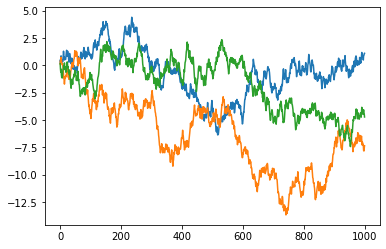

[(array([[0.45065137, 0.16756666, 0.64887543, 0.86013098, 0.37478432],
       [0.11016183, 0.42657545, 0.29249416, 0.72387234, 0.50356234]]), -0.8304239260670685), (array([[ 0.44089095,  0.31944809,  0.44145645,  0.3174164 ,  0.53193794],
       [ 0.23229899,  0.15576356,  0.03293378,  0.1176496 , -0.05326941]]), -0.4148393829920538), (array([[ 0.84162448,  1.28446485,  0.99241949,  0.50193774,  0.72796297],
       [-0.45795531, -0.86716337, -1.20947085, -1.32836912, -1.71906591]]), 0.21588358302462463), (array([[ 0.50776117,  0.62624758,  0.55097228,  0.53152427,  0.79176371],
       [-1.3646431 , -1.04221533, -1.18309728, -0.97945627, -0.91332566]]), -0.6357117721470167), (array([[ 1.09395431,  1.36862612,  1.31757654,  0.84315473,  1.16876967],
       [-1.02643377, -0.73103325, -0.3786396 , -0.07328178, -0.36243774]]), 0.17128883059266053), (array([[ 1.26833878,  0.84502017,  0.88817169,  0.49478047,  0.28240342],
       [-0.7039658 , -0.81080002, -1.11529363, -0.89044147, -1.284336

In [ ]:
n_vars = 3

t = (np.random.rand(1000, n_vars) - .5).cumsum(0)
print(t.shape)
plt.plot(t)
plt.show()
X, y = SlidingWindow(5, stride=None, horizon=0, get_x=[0,1], get_y=2)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

In [ ]:
wl = 5
n_vars = 3

t = (np.random.rand(100, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, horizon=0, get_x=columns[:-1], get_y='target')(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

(100, 3)


,var_0,var_1,target
0,0.356817,0.495009,-0.041134
1,0.786057,0.067351,-0.336206
2,0.292246,-0.075289,-0.081602
3,0.446059,-0.520256,-0.123875
4,0.141255,-0.888804,-0.125197
...,...,...,...
95,-3.086174,-1.064788,-2.401886
96,-2.947199,-1.486815,-2.215417
97,-2.688269,-1.591162,-2.670292
98,-2.692747,-1.792084,-2.408779


[(array([[ 0.35681694,  0.78605749,  0.29224573,  0.44605861,  0.1412545 ],
       [ 0.49500945,  0.06735054, -0.07528927, -0.52025613, -0.88880365]]), -0.12519728625576954), (array([[ 0.78605749,  0.29224573,  0.44605861,  0.1412545 , -0.16806061],
       [ 0.06735054, -0.07528927, -0.52025613, -0.88880365, -0.48982831]]), -0.36401054592011706), (array([[ 0.29224573,  0.44605861,  0.1412545 , -0.16806061, -0.28666225],
       [-0.07528927, -0.52025613, -0.88880365, -0.48982831, -0.41721889]]), -0.6100388454951802), (array([[ 0.44605861,  0.1412545 , -0.16806061, -0.28666225, -0.34652471],
       [-0.52025613, -0.88880365, -0.48982831, -0.41721889, -0.02145412]]), -0.7457352961617472), (array([[ 0.1412545 , -0.16806061, -0.28666225, -0.34652471, -0.75535456],
       [-0.88880365, -0.48982831, -0.41721889, -0.02145412,  0.04868627]]), -0.3915010280284127), (array([[-0.16806061, -0.28666225, -0.34652471, -0.75535456, -1.01692491],
       [-0.48982831, -0.41721889, -0.02145412,  0.0486862

In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=True)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

(100, 5)


,var_0,var_1,var_2,var_3,target
0,-0.312906,0.310280,-0.120191,0.175908,0.275943
1,-0.783660,0.323489,-0.558125,-0.297195,0.593279
2,-1.049468,0.264293,-0.858355,-0.668679,0.107511
3,-1.259120,0.144215,-0.872008,-0.455629,0.451992
4,-1.280246,0.392784,-0.536001,-0.110893,0.082425
...,...,...,...,...,...
95,0.802588,1.421917,-0.768859,-0.126587,-4.023007
96,0.807348,1.083997,-0.698779,-0.000122,-3.672249
97,0.980213,0.637676,-0.569060,-0.453099,-3.879785
98,0.756934,0.480557,-1.067633,-0.029079,-3.595738


[(array([[-0.31290615, -0.78366005, -1.04946782, -1.25911997, -1.28024603],
       [ 0.3102798 ,  0.32348911,  0.26429312,  0.14421476,  0.3927836 ],
       [-0.12019103, -0.55812464, -0.85835527, -0.87200757, -0.53600102],
       [ 0.1759076 , -0.29719476, -0.66867917, -0.45562868, -0.11089346]]), 0.08242549254187903), (array([[-0.78366005, -1.04946782, -1.25911997, -1.28024603, -0.99184683],
       [ 0.32348911,  0.26429312,  0.14421476,  0.3927836 ,  0.02584871],
       [-0.55812464, -0.85835527, -0.87200757, -0.53600102, -0.33418619],
       [-0.29719476, -0.66867917, -0.45562868, -0.11089346, -0.48004177]]), 0.4404181267802727), (array([[-1.04946782, -1.25911997, -1.28024603, -0.99184683, -0.77202012],
       [ 0.26429312,  0.14421476,  0.3927836 ,  0.02584871, -0.35984818],
       [-0.85835527, -0.87200757, -0.53600102, -0.33418619, -0.14956842],
       [-0.66867917, -0.45562868, -0.11089346, -0.48004177, -0.05711299]]), 0.8856026783671908), (array([[-1.25911997, -1.28024603, -0.

In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
columns=[f'var_{i}' for i in range(n_vars-1)] + ['target']
df = pd.DataFrame(t, columns=columns).T
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=False)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
var_0,0.382239,0.103164,0.150702,0.198335,0.013336,0.347213,-0.083232,-0.191927,-0.652935,-0.926190,...,4.790805,4.954039,4.727907,4.997048,4.830185,4.829521,4.738025,4.916021,4.612581,4.790530
var_1,0.364945,0.793411,0.449476,0.021103,0.334476,0.455039,0.790357,0.396854,0.014075,-0.245710,...,-3.049074,-3.213836,-3.380160,-3.835082,-4.157074,-4.252901,-4.409633,-4.305318,-4.211029,-4.089688
var_2,-0.103728,0.191347,-0.001635,-0.411919,-0.159915,-0.611030,-1.096349,-0.756414,-1.245225,-1.075043,...,1.212565,1.283726,1.398986,1.588589,2.000023,1.772798,1.406391,1.719582,2.192150,1.897507
var_3,-0.294864,-0.424604,-0.817916,-0.955924,-0.696474,-0.931725,-1.096793,-0.869935,-1.030228,-1.506012,...,-5.277446,-5.371414,-5.364336,-5.181697,-5.226768,-4.865674,-5.177608,-4.789980,-4.318017,-4.438871
target,-0.381531,-0.224021,0.175334,0.192955,0.472039,0.833549,0.948226,0.786490,1.174029,0.942491,...,0.247241,0.701913,1.009631,1.209845,1.317157,1.415213,1.400435,1.257285,0.952798,0.567990


[(array([[ 0.38223882,  0.10316372,  0.15070181,  0.19833492,  0.01333571],
       [ 0.36494538,  0.79341058,  0.44947562,  0.02110323,  0.33447642],
       [-0.10372775,  0.19134712, -0.00163528, -0.4119194 , -0.15991509],
       [-0.29486383, -0.42460442, -0.81791594, -0.95592357, -0.69647382]]), 0.4720393301783391), (array([[ 0.10316372,  0.15070181,  0.19833492,  0.01333571,  0.34721327],
       [ 0.79341058,  0.44947562,  0.02110323,  0.33447642,  0.45503939],
       [ 0.19134712, -0.00163528, -0.4119194 , -0.15991509, -0.61102999],
       [-0.42460442, -0.81791594, -0.95592357, -0.69647382, -0.93172519]]), 0.8335493696017694), (array([[ 0.15070181,  0.19833492,  0.01333571,  0.34721327, -0.08323227],
       [ 0.44947562,  0.02110323,  0.33447642,  0.45503939,  0.79035695],
       [-0.00163528, -0.4119194 , -0.15991509, -0.61102999, -1.09634926],
       [-0.81791594, -0.95592357, -0.69647382, -0.93172519, -1.0967926 ]]), 0.9482258225379326), (array([[ 0.19833492,  0.01333571,  0.3

In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
columns=[f'var_{i}' for i in range(n_vars-1)] + ['target']
df = pd.DataFrame(t, columns=columns).T
display(df)
X, y = SlidingWindow(5, stride=None, horizon=0, get_x=columns[:-1], get_y='target', seq_first=False)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
var_0,0.034802,-0.132860,-0.429032,-0.341473,-0.378150,-0.402992,-0.484306,-0.381106,-0.222279,-0.474040,...,-2.799021,-2.991532,-3.399924,-3.286931,-2.931003,-2.484587,-2.882005,-2.987873,-2.618916,-2.888120
var_1,0.107676,0.205584,-0.257217,-0.220571,0.023184,0.342150,0.213801,0.313315,0.774487,0.719421,...,5.340309,5.059796,5.183145,5.109861,5.167735,4.950955,5.091830,4.977777,5.150588,5.103563
var_2,0.343144,-0.053232,-0.180245,-0.579791,-0.719142,-1.168609,-0.687241,-0.874597,-0.751566,-0.490478,...,1.309515,1.699589,2.091369,2.131531,2.406308,2.008641,2.008878,1.909823,1.472527,1.693775
var_3,-0.234060,0.089083,0.257208,0.226243,0.455521,0.740873,0.471033,0.832255,0.696981,1.026359,...,1.033317,0.607112,0.834631,0.608126,0.966205,0.678891,0.736319,0.938414,0.759803,0.401165
target,-0.338837,-0.284471,-0.174718,-0.434344,0.032864,0.289161,-0.078845,0.297673,0.125255,-0.010372,...,-2.750986,-3.187120,-3.666896,-4.000539,-3.765179,-4.220156,-3.877641,-3.621384,-3.284778,-3.676608


[(array([[ 0.03480222, -0.1328596 , -0.42903182, -0.34147326, -0.37815025],
       [ 0.10767566,  0.20558362, -0.25721731, -0.22057133,  0.02318364],
       [ 0.34314399, -0.05323201, -0.18024507, -0.57979071, -0.71914181],
       [-0.23405967,  0.08908287,  0.25720823,  0.22624299,  0.4555211 ]]), 0.03286437213272231), (array([[-0.40299198, -0.48430637, -0.38110592, -0.22227902, -0.47403956],
       [ 0.34215004,  0.21380064,  0.31331472,  0.77448717,  0.71942098],
       [-1.16860864, -0.6872405 , -0.87459669, -0.75156592, -0.4904777 ],
       [ 0.74087314,  0.47103252,  0.83225511,  0.6969812 ,  1.02635865]]), -0.010371875202551006), (array([[-0.83576913, -1.03053047, -0.92524231, -1.19947269, -0.93551489],
       [ 0.48217307,  0.79587238,  0.66000522,  0.61927475,  0.55075566],
       [-0.71824163, -0.32681674, -0.31068913, -0.10600302, -0.14783772],
       [ 0.92323058,  1.11060875,  0.92103877,  1.38060483,  0.98146295]]), -0.6889695562619644), (array([[-5.59056267e-01, -6.05216

In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=True)(df)
splits = TrainValidTestSplitter(valid_size=.2, shuffle=False)(y)
X.shape, y.shape, splits

(100, 5)


,var_0,var_1,var_2,var_3,target
0,0.312564,0.411039,0.324129,0.102452,0.499671
1,0.761632,0.323054,0.187355,0.142048,0.780415
2,0.279824,0.054273,-0.180501,-0.093385,0.393888
3,0.110029,-0.110317,0.147883,0.199077,0.069014
4,-0.103076,-0.252707,0.248960,0.098338,0.294190
...,...,...,...,...,...
95,-0.914073,-1.516258,1.058316,0.848464,2.304592
96,-0.744108,-1.890252,0.639337,1.303733,2.530206
97,-0.353748,-1.917389,0.823221,1.311779,2.739495
98,-0.641502,-2.045090,0.690578,1.591838,3.023526


((96, 4, 5),
 (96,),
 ((#77) [0,1,2,3,4,5,6,7,8,9...], (#19) [77,78,79,80,81,82,83,84,85,86...]))

In [ ]:
#export
def SlidingWindowPanel(window_len:int, unique_id_cols:list, stride:Union[None, int]=1, start:int=0, get_x:Union[None, int, list]=None,  
                       get_y:Union[None, int, list]=None, y_func:Optional[callable]=None, horizon:Union[int, list]=1, seq_first:bool=True, 
                       sort_by:Optional[list]=None, ascending:bool=True, check_leakage:bool=True, return_key:bool=False, verbose:bool=True):

    """
    Applies a sliding window to a 1d or 2d input (np.ndarray, torch.Tensor or pd.DataFrame)
    
    Args:
        window_len      = length of lookback window
        unique_id_cols  = columns that will be used to identify a time series for each entity.
        stride          = n datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_len (no overlap)
        start           = determines the step where the first window is applied: 0 (default), a given step (int), or random within the 1st stride (None). 
        horizon         = number of future datapoints to predict:
                            * 0 for last step in each sub-window. 
                            * n > 0 for a range of n future steps (1 to n). 
                            * n < 0 for a range of n past steps (-n + 1 to 0).
                            * list : for those exact timesteps.
        get_x           = indices of columns that contain the independent variable (xs). If None, all data will be used as x.
        get_y           = indices of columns that contain the target (ys). If None, all data will be used as y. [] means no y data is created.
        y_func          = function to calculate the ys based on the get_y col/s and each y sub-window. y_func must be a function applied to axis=1!
        seq_first       = True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len)
        sort_by         = column/s used for sorting the array in ascending order
        ascending       = used in sorting
        check_leakage   = checks if there's leakage in the output between X and y
        return_key      = when True, the key corresponsing to unique_id_cols for each sample is returned
        
        
    Input:
        You can use np.ndarray, pd.DataFrame or torch.Tensor as input
        shape: (seq_len, ) or (seq_len, n_vars) if seq_first=True else (n_vars, seq_len)
    """
    
    sort_by = unique_id_cols + (sort_by if sort_by is not None else [])
    
    def _SlidingWindowPanel(df):
        
        df.sort_values(by=sort_by, axis=0, ascending=ascending, inplace=True, ignore_index=True)
        unique_id_values = df[unique_id_cols].drop_duplicates().values
        _x = []
        _y = []
        _key = []
        for i, v in enumerate(progress_bar(unique_id_values)):
            x_v, y_v = SlidingWindow(window_len, stride=stride, start=start, get_x=get_x, get_y=get_y, y_func=y_func, 
                                     horizon=horizon, seq_first=seq_first, check_leakage=check_leakage)(df[(df[unique_id_cols].values == v).sum(axis=1) == len(v)])                                
            if x_v is not None and len(x_v) > 0: 
                _x.append(x_v)
                if return_key: _key.append([v.tolist()] * len(x_v))
                if y_v is not None and len(y_v) > 0: _y.append(y_v)
            else: pv(f'cannot use {unique_id_cols} = {v} due to not having enough records', verbose)

        X = concat(*_x)
        if _y != []:
            y = concat(*_y)
            for d in np.arange(1, y.ndim)[::-1]:
                if y.shape[d] == 1: y = np.squeeze(y, axis=d)
        else: y = None
        if return_key: 
            key = np.concatenate(_key)
            if key.ndim == 2 and key.shape[-1] == 1: key = np.squeeze(key, -1)
            if return_key: return X, y, key
        else: return X, y
        
    return _SlidingWindowPanel

In [ ]:
samples = 100_000
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(samples)]).T * tensor([10**i for i in range(n_vars)]))
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
df['time'] = np.arange(len(t))
df['device'] = 0
df['target'] = np.random.randint(0, 2, len(df))
df2 = df.copy()
df3 = df.copy()
cols = ['var_0', 'var_1', 'var_2', 'device', 'target']
df2[cols] = df2[cols] + 1
df3[cols] = df3[cols] + 2
df2 = df2.loc[:3]
df['region'] = 'A'
df2['region'] = 'A'
df3['region'] = 'B'
df = df.append(df2).append(df3).reset_index(drop=True)
df['index'] = np.arange(len(df))
df = df.sample(frac=1).reset_index(drop=True)
display(df.head())
df.shape

,var_0,var_1,var_2,time,device,target,region,index
0,77047,770470,7704700,77047,0,1,A,77047
1,87689,876890,8768900,87689,0,1,A,87689
2,93190,931900,9319000,93190,0,1,A,93190
3,10766,107642,1076402,10764,2,3,B,110768
4,38448,384462,3844602,38446,2,3,B,138450


(200004, 8)

In [ ]:
X, y = SlidingWindowPanel(window_len=5, unique_id_cols=['device'], stride=1, start=0, get_x=['var_0', 'var_1', 'var_2', 'index', 'device'], get_y=['target'], 
                          horizon=0, seq_first=True, sort_by=['time'], ascending=True, return_key=False)(df)
X.shape, y.shape

cannot use ['device'] = [1] due to not having enough records


((199992, 5, 5), (199992,))

In [ ]:
X, y, key = SlidingWindowPanel(window_len=5, unique_id_cols=['device'], stride=1, start=0, get_x=[0, 1, 2], get_y=['target'], 
                               horizon=0, seq_first=True, sort_by=['time'], ascending=True, return_key=True)(df)
X.shape, y.shape, key.shape

cannot use ['device'] = [1] due to not having enough records


((199992, 3, 5), (199992,), (199992,))

In [ ]:
X, y = SlidingWindowPanel(window_len=5, unique_id_cols=['device', 'region'], stride=1, start=0, get_x=['var_0', 'var_1', 'var_2'], get_y=['target'], 
                          horizon=0, seq_first=True, sort_by=['time'], ascending=True)(df)
X.shape, y.shape

cannot use ['device', 'region'] = [1 'A'] due to not having enough records


((199992, 3, 5), (199992,))

In [ ]:
# y_func must be a function applied to axis=1!
def y_max(o): return np.max(o, axis=1)

In [ ]:
X, y = SlidingWindowPanel(window_len=5, unique_id_cols=['device', 'region'], stride=1, start=0, get_x=['var_0', 'var_1', 'var_2'], get_y=['target'], 
                          y_func=y_max, horizon=5, seq_first=True, sort_by=['time'], ascending=True)(df)
X.shape, y.shape

cannot use ['device', 'region'] = [1 'A'] due to not having enough records


((199982, 3, 5), (199982,))

In [ ]:
#hide
out = create_scripts(); beep(out)

<IPython.core.display.Javascript object>

Converted 000_utils.ipynb.
Converted 000b_data.validation.ipynb.
Converted 000c_data.preparation.ipynb.
Converted 001_data.external.ipynb.
Converted 002_data.core.ipynb.
Converted 003_data.preprocessing.ipynb.
Converted 003b_data.transforms.ipynb.
Converted 003c_data.mixed_augmentation.ipynb.
Converted 003d_data.image.ipynb.
Converted 003e_data.features.ipynb.
Converted 005_data.tabular.ipynb.
Converted 006_data.mixed.ipynb.
Converted 007_metrics.ipynb.
Converted 008_learner.ipynb.
Converted 009_optimizer.ipynb.
Converted 010_callback.core.ipynb.
Converted 011_callback.semi_supervised.ipynb.
Converted 012_callback.gblend.ipynb.
Converted 100_models.utils.ipynb.
Converted 100b_models.layers.ipynb.
Converted 100c_models.explainability.ipynb.
Converted 101_models.ResNet.ipynb.
Converted 101b_models.ResNetPlus.ipynb.
Converted 102_models.InceptionTime.ipynb.
Converted 102b_models.InceptionTimePlus.ipynb.
Converted 103_models.MLP.ipynb.
Converted 103b_models.FCN.ipynb.
Converted 103c_models